## Example Network using QAOA ##

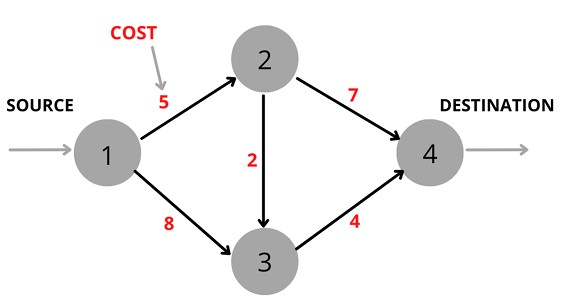


<br>
First we have to create the problem Hamiltonian in the Ising model and add a mixer Hamiltonian for optimizing using QAOA. To generate the Hamiltonian, we use the QUBO method, used in various other combinatorial problems.

In [35]:
from pyqubo import Array,Constraint,Placeholder
from matplotlib import pyplot as plt
import networkx as nx

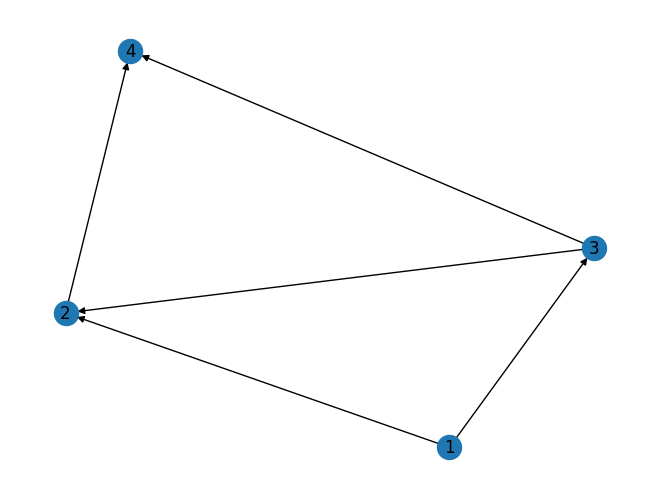

In [36]:
edges = [(1,2),(1,3),(3,2),(2,4),(3,4)]
weights = [5,8,2,7,4] 

x = Array.create(name = 'x', shape =len(edges), vartype = 'BINARY') #SPIN

graph = nx.DiGraph(edges)
nx.draw(graph, with_labels=True)
plt.show()
source = 1
destination = 4

In [37]:
print(x.shape)
print(x)
y = (4*x[0]+x[1])
print(y)

(5,)
Array([Binary('x[0]'), Binary('x[1]'), Binary('x[2]'), Binary('x[3]'), Binary('x[4]')])
((4.000000 * Binary('x[0]')) + Binary('x[1]'))


In [38]:
# model = ((x[0] + x[1] - 1)).compile()
# print(model.to_qubo())

In [39]:
i = 0
fcost = 0
for i in range(len(edges)):
    fcost += (weights[i]*x[i]) ## Put the expression for constraints in

p = 27 # chosen arbitrarily. It represents the penalty for the constraints. Also another parameter that can be varied

## Constraints ##
fcost += p*((x[0] + x[1] - 1)**2) 
fcost += p*((x[0] - x[2] - x[3])**2)
fcost += p*((x[1] + x[2] - x[4])**2)

In [40]:
model = fcost.compile()

In [41]:
print(model.to_qubo())

({('x[4]', 'x[1]'): -54.0, ('x[0]', 'x[0]'): 5.0, ('x[2]', 'x[2]'): 56.0, ('x[4]', 'x[2]'): -54.0, ('x[1]', 'x[2]'): 54.0, ('x[1]', 'x[1]'): 8.0, ('x[3]', 'x[0]'): -54.0, ('x[1]', 'x[0]'): 54.0, ('x[2]', 'x[0]'): -54.0, ('x[2]', 'x[3]'): 54.0, ('x[4]', 'x[4]'): 31.0, ('x[3]', 'x[3]'): 34.0}, 27.0)


In [42]:
linear, quadratic, offset = model.to_ising()
print("Linear Coefficients", linear)
print("Quadratic Coefficients", quadratic)

## The objective function is then made from these linear and quadratic terms ##
## The objective function represents the Problem Hamiltonian Hp ##

Linear Coefficients {'x[0]': -11.0, 'x[1]': 17.5, 'x[2]': 28.0, 'x[3]': 17.0, 'x[4]': -11.5}
Quadratic Coefficients {('x[0]', 'x[1]'): 13.5, ('x[0]', 'x[2]'): -13.5, ('x[2]', 'x[3]'): 13.5, ('x[0]', 'x[3]'): -13.5, ('x[2]', 'x[4]'): -13.5, ('x[1]', 'x[2]'): 13.5, ('x[1]', 'x[4]'): -13.5}


In [43]:
#s = 'x['+str(0)+']'
#print(linear.get(s))

In [44]:
# print(int(list(quadratic.keys())[0][1][2]))

The above coefficients correspond to the following Objective Function:

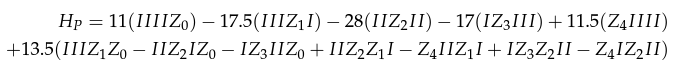

<br>
This Objective function ultimately corresponds to the following circuit:

<img src="qaoa.png">

In [45]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import string
import time

In [46]:
# AWS imports: Import Braket SDK modules
!pip install amazon-braket-sdk
from braket.circuits import Circuit, Gate, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsQuantumTask

In [47]:
def create_circuit(beta, gamma):
    ## initializing the initial qubit state with H gates ##
    circuit = Circuit()
    n_qubits = len(edges)

    for qubit in range(n_qubits):
        circuit.h(qubit)
    
    ## Implementing the problem Hamiltonian ##
    for qubit in range(n_qubits):
        linear_coeff = linear.get('x['+str(qubit)+']')
        circuit = circuit.rz(qubit, -1*linear_coeff)

    #Algorithmic method to add the ZZ gates - CHECK TO SEE IF IT AFFECTS THE RESULTS(it should'nt because they commute)
    for i in range(len(quadratic)):
        qubit_1 = int(list(quadratic.keys())[i][0][2])
        qubit_2 = int(list(quadratic.keys())[i][1][2])

        quadratic_coeff = quadratic.get(('x['+str(qubit_1)+']', 'x['+str(qubit_2)+']'))
        
    # The Ising-Coupling Gate
        #circuit.zz(qubit_1, qubit_2, quadratic_coeff*gamma)
        circuit.cnot(control=qubit_1, target=qubit_2)
        circuit.rz(qubit_2, quadratic_coeff*gamma)
        circuit.cnot(control=qubit_1, target=qubit_2)
    
    ## Implementing the Mixer Hamiltonian ##
    for qubit in range(n_qubits):
        circuit.rx(qubit, 2*beta) # theta=2*beta because rx rotates the qubit about X by theta/2 angle
    return circuit

In [48]:
def execute_calibration(circuit):
    device = LocalSimulator()
    #device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")
    shots = 1024
    result = device.run(circuit, shots).result()
    counts = result.measurement_counts
    expectation = 0
    sum = 0
    states = list(counts.keys())
    for i in range(len(states)):
        state = states[i] # string variable of the current qubit states
        state_cost = 0
        for j in range(len(state)): # Convention of the states is that the left-most qubit is the first qubit q0
            state_cost = state_cost + int(state[j])*weights[j]
        
        expectation = expectation + state_cost*counts.get(state)
        
    expectation /= shots
    # print(expectation)
    return expectation

In [54]:
circuit = create_circuit(0.28517317, -5.05969577)

from mitiq import zne
unmitigated = execute_calibration(circuit)
mitigated = zne.execute_with_zne(circuit, executor=execute_calibration)
print(f"Unmitigated result {unmitigated:.3f}")
print(f"Mitigated result {mitigated:.3f}")

Unmitigated result 12.448
Mitigated result 12.087


In [55]:
factory = zne.inference.LinearFactory(scale_factors=[1.0, 1.5, 2.0, 2.5, 3.0])
noise_scaling_method = zne.scaling.fold_global

mitigated = zne.execute_with_zne(
    circuit,
    execute_calibration,
    factory=factory,
    scale_noise=noise_scaling_method, 
)
print(f"Mitigated result {mitigated:.3f}")

Mitigated result 12.331


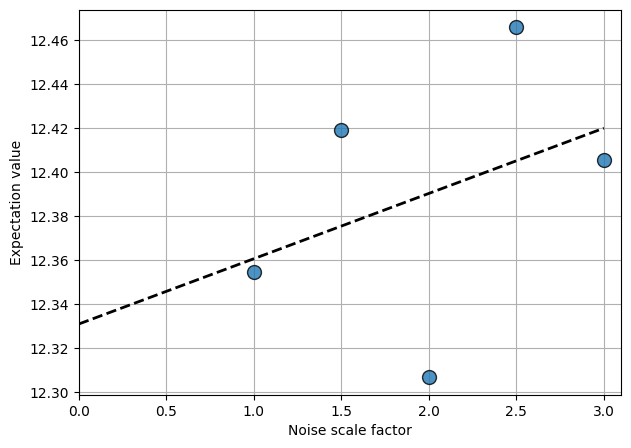

In [56]:
_ = factory.plot_fit()